In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam

In [3]:
# Load every preprocessed data
dataset = np.load("utils//preprocessed.npz")
x = dataset['x']

In [47]:
def generator(noise_shape):
    model = Sequential(name='generator')
    
    # Random Noise to 4x4x512
    model.add(Dense(4*4*512, input_shape=[noise_shape]))
    
    # Reshape reverse into 512x4x4
    model.add(Reshape([4, 4, 512]))
    model.add(Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding="same"))
    model.add(ReLU())
    model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding="same"))
    model.add(ReLU())
    model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same"))
    model.add(ReLU())
    model.add(BatchNormalization())
    
    # Output with tanh
    model.add(Conv2DTranspose(3, kernel_size=(2, 2), strides=(2, 2), padding="same", activation='tanh'))
    
    return model

generator = generator(100)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8192)              827392    
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 8, 8, 32)         65568     
 ranspose)                                                       
                                                                 
 re_lu_6 (ReLU)              (None, 8, 8, 32)          0         
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 32)         128       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 16, 16, 64)       32

In [48]:
def discriminator():
    model = Sequential(name='discriminator')
    model.add(Conv2D(24, (3, 3), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization())
    
    model.add(Flatten())
    #model.add(Dense(256))
    #model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(optimizer=opt, loss='binary_crossentropy')
    
    return model

discriminator = discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 24)        672       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 24)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        6944      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_5 (Dense)             (None, 1)               

In [49]:
discriminator.trainable = False
gan = Sequential([generator, discriminator])

gan_optiimzer = Adam(learning_rate=0.0002, beta_1=0.5)
gan.compile(optimizer=gan_optiimzer, loss='binary_crossentropy')
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 64, 64, 3)         961123    
                                                                 
 discriminator (Sequential)  (None, 1)                 15809     
                                                                 
Total params: 976,932
Trainable params: 960,675
Non-trainable params: 16,257
_________________________________________________________________


In [50]:
EPOCHS = 300
BATCH_SIZE = 256

In [51]:
def train(gan, discriminator, generator, EPOCHS, BATCH_SIZE):
    iter_delete = 0

    d_loss_fake_list = []
    d_loss_real_list = []
    g_loss_list = []
    with tf.device('/gpu:0'):
        for epoch in range(EPOCHS):
            batch = x.shape[0] // BATCH_SIZE
            for i in range(batch):
                if (i) % 100 == 0:
                    print(f"\t Batch : {i} of {len(x)//BATCH_SIZE}")

                # Generate random seed as input to produce an image
                noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, 100])

                '''
                predict() - eventually go through all the data batch by batch then predict the labels and it also split the batch at a time
                predict_on_batch() - on the other hand this method with assumption thee data only pass to one batch without any split
                '''
                # The generator fake noise prediction will be passed to calculate loss
                gen_image = generator.predict_on_batch(noise)

                # Take real data
                # sampling a batch of real from the dataset
                train_dataset = x[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

                # Train Discriminator
                # Make the discriminator be able to train
                discriminator.trainable = True

                # Fake labels = 0 and True labels = 1

                # Train the discriminator on real images with real label
                # Returning in loss calculation
                train_labels_real = np.ones(shape=(BATCH_SIZE, 1))
                d_loss_real = discriminator.train_on_batch(train_dataset, train_labels_real)

                # Train the discriminator on fake images with fake labels
                # Returning in loss calculation
                train_labels_fake = np.zeros(shape=(BATCH_SIZE, 1))
                d_loss_fake = discriminator.train_on_batch(gen_image, train_labels_fake)

                # Variables to whole adversarial network
                noise_ = np.random.uniform(-1, 1, size=[BATCH_SIZE, 100])

                # Image label that equal to 1, to fool the discriminator
                train_label_fake_training = np.ones(shape=(BATCH_SIZE, 1))

                # Make the discriminator are not be able to train
                discriminator.trainable = False

                # Train the Generator
                # The discriminator has been freezed and only train generator
                g_loss = gan.train_on_batch(noise_, train_label_fake_training)
            
                if iter_delete == 100:
                    os.system('clear')
                    iter_delete = 0
                else:
                    d_loss_fake_list.append(d_loss_fake)
                    d_loss_real_list.append(d_loss_real)
                    g_loss_list.append(g_loss)
                    print("Epoch :%d, batch :%d, d1_real:%.10f, d2_fake:%.10f, g_loss:%.10f" % (epoch, i, d_loss_real, d_loss_fake, g_loss))
                    iter_delete = iter_delete + 1
        
        return generator, discriminator, gan, (d_loss_fake_list, d_loss_real_list, g_loss_list)


In [52]:
generator, discriminator, gan, loss_track = train(gan, discriminator, generator, EPOCHS, BATCH_SIZE)

	 Batch : 0 of 84
Epoch :0, batch :0, d1_real:0.7092192769, d2_fake:0.6933703423, g_loss:0.6648221612
Epoch :0, batch :1, d1_real:0.5981638432, d2_fake:0.6939348578, g_loss:0.6019141078
Epoch :0, batch :2, d1_real:0.5197700262, d2_fake:0.6944545507, g_loss:0.5235009193
Epoch :0, batch :3, d1_real:0.4553676546, d2_fake:0.6949615479, g_loss:0.4704835415
Epoch :0, batch :4, d1_real:0.3891832530, d2_fake:0.6954171658, g_loss:0.4190372527
Epoch :0, batch :5, d1_real:0.3309900761, d2_fake:0.6955899000, g_loss:0.3590979576
Epoch :0, batch :6, d1_real:0.2810956836, d2_fake:0.6956096292, g_loss:0.3153051436
Epoch :0, batch :7, d1_real:0.2351450920, d2_fake:0.6953108907, g_loss:0.2724446058
Epoch :0, batch :8, d1_real:0.1929889768, d2_fake:0.6947506666, g_loss:0.2370700836
Epoch :0, batch :9, d1_real:0.1680378765, d2_fake:0.6938844919, g_loss:0.1989914924
Epoch :0, batch :10, d1_real:0.1356535852, d2_fake:0.6926916242, g_loss:0.1744692177
Epoch :0, batch :11, d1_real:0.1152375638, d2_fake:0.6910

Text(0.5, 1.0, 'Discriminator Fake Loss')

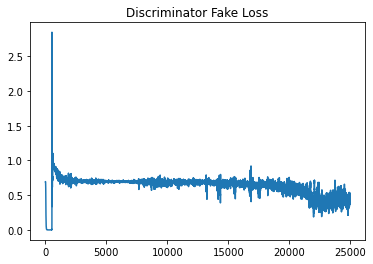

In [53]:
# Discriminator Fake loss
plt.plot(np.array(loss_track[0]))
plt.title("Discriminator Fake Loss")
#plt.savefig("result/result_tenth_d_fakeloss.jpg")

Text(0.5, 1.0, 'Discriminator Real Loss')

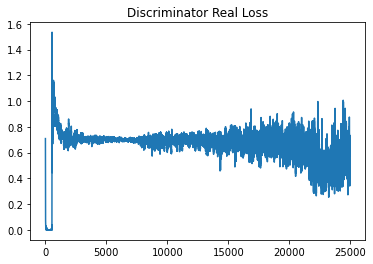

In [54]:
# Discriminator Real loss
plt.plot(np.array(loss_track[1]))
plt.title("Discriminator Real Loss")
#plt.savefig("result/result_tenth_d_realloss.jpg")

Text(0.5, 1.0, 'Generator Loss')

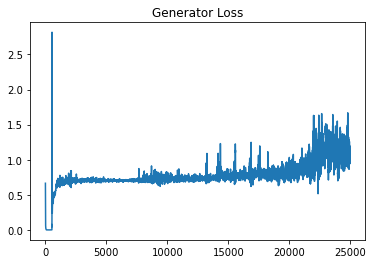

In [55]:
# Generator Fake loss
plt.plot(np.array(loss_track[2]))
plt.title("Generator Loss")
#plt.savefig("result/result_tenth_g_loss.jpg")

In [10]:
generator.save("utils//generator.h5")
discriminator.save("utils//discriminator.h5")
gan.save("utils//gan.h5")

In [11]:
#model = tf.keras.models.load_model("utils//generator.h5")
#model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              827392    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         2097408   
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 128)       0 

In [56]:
#noise = np.random.uniform(-1,1,size=[5,100])
noise = np.load("utils//noise.npz")
noise = noise['noise']

im = generator.predict(noise)

1/1 [==============================] - 0s 127ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


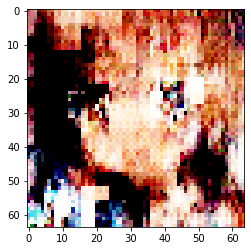

In [55]:
plt.imshow(im[0])
plt.savefig('result/sixth_noticable.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


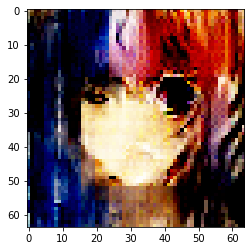

In [57]:
plt.imshow(im[0])
#plt.savefig('result/ninth_noticable.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


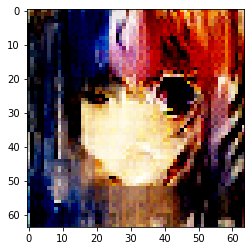

In [58]:
plt.imshow(im[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


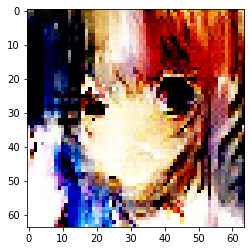

In [59]:
plt.imshow(im[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


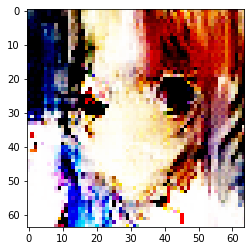

In [60]:
plt.imshow(im[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


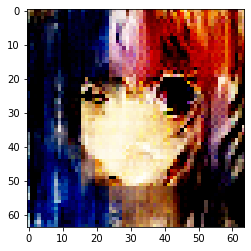

In [61]:
plt.imshow(im[4])
plt.savefig('result/tenth_noticable_1.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


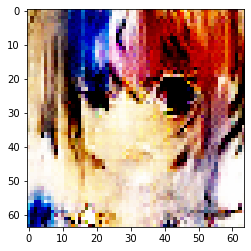

In [62]:
plt.imshow(im[5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


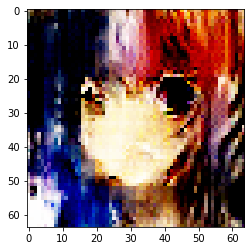

In [63]:
plt.imshow(im[6])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


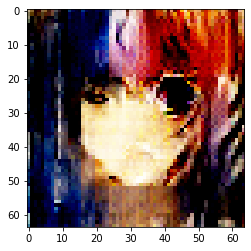

In [64]:
plt.imshow(im[7])
plt.savefig('result/tenth_noticable_2.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


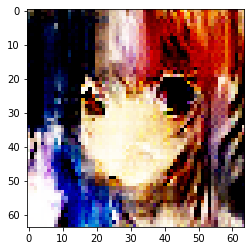

In [65]:
plt.imshow(im[8])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


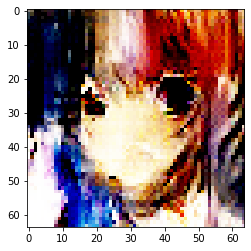

In [66]:
plt.imshow(im[9])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


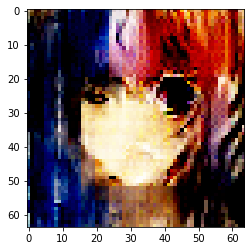

In [67]:
plt.imshow(im[0])